Note: This is a binary classification implementation. Implement/use Softmax Regression for multi-class classification.

In [142]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt

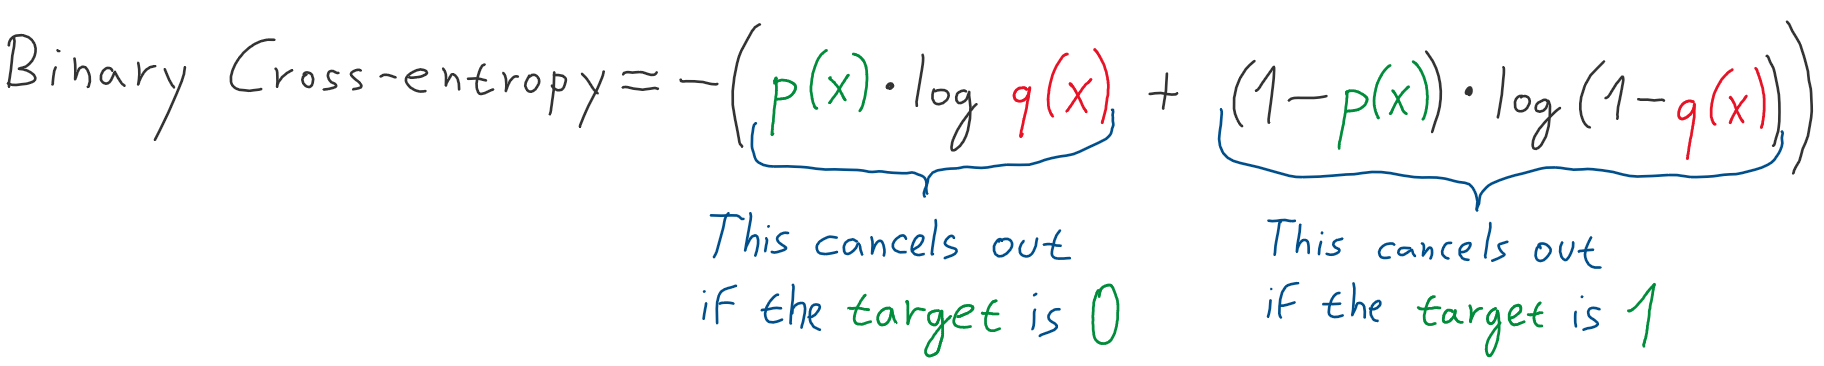

In [85]:
def normalize(x,axis=0):
    return (x-x.mean(0))/x.std(0)

def sigmoid(x,der=False):
    return 1 / (1+np.exp(-x)) if not der else sigmoid(x)*(1-sigmoid(x))

def ce_loss(logits,y):
    eps = 1e-20
    return -sum(y*np.log(logits+eps) + (1-y)*np.log(1-logits+eps))

class LogisticRegression:
    def __init__(self,lr=.01):
        self.lr = lr
    
    def forward(self,x):
        return sigmoid((x@self.w)) 
    
    def epoch(self):
        self.z = self.forward(self.x)
        loss = ce_loss(self.z,self.y)
        self.losses.append(loss)
        # gradients. calculated manually and verified here https://www.textbook.ds100.org/ch/17/classification_cost.html
        grad = self.z - self.y
        grad_w = grad @ self.x 
        self.w = self.w - (self.lr*grad_w) 
    
    def fit(self,x,y,iters=10): 
        self.x = np.hstack((x,np.ones((x.shape[0],1)))) # adding ones to the features to serve as bias 
        self.y = y
        self.w = np.random.randn(self.x.shape[1])
        self.losses = []
        for i in range(iters):
            self.epoch()
    
    def predict(self,x, thresh=.5, return_logits=False):
        x = np.hstack((x,np.ones((x.shape[0],1))))
        logits = self.forward(x)
        preds = (logits > thresh).astype(int)
        if return_logits: 
            return (preds,logits)
        else:
            return preds
    

In [86]:
x,y = load_breast_cancer(return_X_y=True)

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

In [88]:
model = LogisticRegression()
model.fit(x_train,y_train)
model.losses

[873.122942189295,
 230.98693386510595,
 154.56790594141052,
 107.29176772927799,
 79.17718575253176,
 66.29385446776536,
 58.94277721199729,
 53.110502630904186,
 48.63787620725764,
 45.56308154519279]

In [89]:
# train accuracy
preds = model.predict(x_train)
print("train accuracy:", (preds==y_train).mean())

# valid accracy
preds = model.predict(x_test)
print("valid accuracy:", (preds==y_test).mean())

train accuracy: 0.9763779527559056
valid accuracy: 0.9680851063829787


## Assumption of Logistic Regression: Linear relationship between W*X and Y

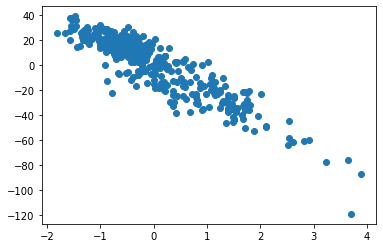

In [119]:
x_train_wbias = np.hstack((x_train,np.ones((x_train.shape[0],1))))
u = x_train_wbias @ model.w # before sigmoid is applied
# we assume a linear relationship between and in this case we would be correct for feature 0
plt.scatter(x=x_train_wbias[:,0],y=u)

# Interpreting Coefficients 

The coefficient value represents the change in log odds caused by one unit change in the feature. In the following example, we add `1` to the first feature, `mean radius` and prove that the difference in log odds is indeed the same as the coefficient value.

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/

In [153]:
# quick look at the features 
feats = list(load_breast_cancer()["feature_names"]) + ["intercept"]
weights = model.w
coefs = pd.DataFrame({"feat":feats,"coef":weights})
coefs.head()

,feat,coef
0,mean radius,-1.936212
1,mean texture,-2.529100
2,mean perimeter,-0.747086
3,mean area,-2.666119
4,mean smoothness,-1.167982


In [154]:
# get the first sample and make a prediction
sample = np.expand_dims(x_train[0], axis=0)
logit = model.predict(sample,return_logits=True)[1][0]; logit

2.6104354065591492e-06

In [155]:
# add one to the first feature, mean radius and make a new prediction
sample_plus_one = sample.copy()
sample_plus_one[0][0] += 1
logit_plus_one = model.predict(sample_plus_one, return_logits=True)[1][0]; logit_plus_one

3.765544548068972e-07

In [158]:
diff = np.log(logit_plus_one/(1-logit_plus_one)) - np.log(logit/(1-logit)); 
print(diff,model.w[0])

-1.936211871661481 -1.9362118716614805


In [157]:
np.isclose(diff, model.w[0])

True

# Extra

In [91]:
# unoptimal ce_loss implementation (plus derivative)
def ce_loss2(logits,y,der=False):
    assert len(logits) == len(y)
    def proc_one(p,l):
        return p*np.log(l+eps) + (1-p)*np.log(1-l+eps)
    if not der:
        return -sum([proc_one(p,l) for (p,l) in zip(y,logits)])
    else:
        return (logits - y)/(logits - logits**2)

In [92]:
# test: both ce loss functions should be equal
eps = 1e-12
t = np.random.randn(x_train.shape[1])
ce_loss(sigmoid(x_train@t),y_train),ce_loss2(sigmoid(x_train@t),y_train)

(3264.901368596467, 3235.713525997058)

In [93]:
import itertools
list2d = [[1,2,3], [4,5,6], [7], [8,9]]
merged = list(itertools.chain(*list2d))